**New conjectures about regularized function $\nu_{M,K}(s)$**

In [1]:
%matplotlib ipympl
import mpmath as mpm, numpy as np, pandas as pd, matplotlib.pyplot as plt, sys, json
from matplotlib.widgets import Slider
from sympy.abc import n
from ramanujan.pcf import PCF

mpm.mp.dps = 10_000             # Our working precision is of 10000 decimal digits 
sys.set_int_max_str_digits(0)   # Allows to convert strings to mpmath.mpf of arbitrary precision
plt.rcParams['text.usetex'] = True   # Use TEX in matplotlib

In [2]:
def parse_numtuple(s):
    s = s.strip('()')
    lst = s.split(', ')
    lst_num = []
    for item in lst:
        if '//' in item:
            num, den = item.split('//')
            lst_num.append(int(num)/int(den))
        else:
            lst_num.append(int(item))
    return tuple(lst_num)


# scf - returns the simple continued fraction of a floating point x up to depth n. If 
# return_rest == False (its preset value), the output is a vector where the first number 
# is the integer part of x, and the next numbers correspond to the subsequent elements 
# of the continued fraction. If return_rest == True, then it returns as a second output
# the last element of the continued fraction before truncation. 
def scf(x,n,return_rest=False):
    tmp = x
    cf = [int(mpm.floor(x))]
    for _ in range(n):
        tmp = mpm.fmod(tmp,1)
        if tmp == 0:
            tmp = mpm.mpf('inf')
            break
        else:
            tmp = 1/tmp
            cf.append(int(mpm.floor(tmp)))
    if return_rest == False:
        return cf
    else:
        return cf,tmp

# gaussmap - applies the Gauss map x -> 1/(x-floor(x)) if the parameter n is 1 as preset.
# For n != 1, it determines the n-fold composition of the Gauss map on x. 
def gaussmap(x,n=1):
    cf,tmp = scf(x,n,True)
    if (tmp == mpm.mpf('inf')) & (len(cf) < n):
        print(f"Gauss map attains the value +Inf at n={len(cf)}.")
    return tmp


def axis_format(ax,title='',xlabel='',ylabel='',xticks=np.arange(0,1.1,0.1),yticks=np.arange(0,1.1,0.1),epsil_x=0,epsil_y=0):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xbound(xticks[0]-epsil_x,xticks[-1]+epsil_x)
    ax.set_ybound(yticks[0]-epsil_y,yticks[-1]+epsil_y)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.tick_params(axis='both',labelsize=8)
    ax.grid()

mpm.mpf.scf = scf
mpm.mpf.gaussmap = gaussmap

In [ ]:
with open('Data/p10000/nu_M10-10-1500_K500-500-3000_s0ff1-1ff2-2ff1_p10000.json','r') as f:
    nu_coarse = {parse_numtuple(key):mpm.mpf(value) for key,value in json.load(f).items()}

In [3]:
with open('Data/p10000/nu_levelc_M+i_2M_im500-10-500_p10000.json','r') as f:
    nu_levelc = pd.DataFrame.from_dict({parse_numtuple(key):mpm.mpf(value) for key,value in json.load(f).items()},orient='index')
    nu_levelc.index = pd.MultiIndex.from_tuples(nu_levelc.index)
    nu_levelc.index.names = ['k','M']
    nu_levelc.columns = ["nu_even"]

with open('Data/p10000/nu_levelc_M+i_2M-1_im500-10-500_p10000.json','r') as f:
    nu_levelc_odd = pd.DataFrame.from_dict({parse_numtuple(key):mpm.mpf(value) for key,value in json.load(f).items()},orient='index')
    nu_levelc_odd.index = pd.MultiIndex.from_tuples(nu_levelc_odd.index)
    nu_levelc_odd.index.names = ['k','M']
    nu_levelc_odd.columns = ["nu_odd"]

nu_levelc = pd.merge_ordered(nu_levelc,nu_levelc_odd,on=("k","M"),how="outer")
nu_levelc.set_index(['k','M'],inplace=True)
nu_levelc_odd = pd.DataFrame()

__Conjecture 0 (PCF derived from Yuri's work)__. 
The asymptotic equivalence
$$
    \frac1{1 - 4M \cdot \nu_{M,2M}(1)} \sim 4M/1+\cfrac1{4M/2+\cfrac1{4M/3+\cfrac1{{\, 4M/4 + \ddots}^{\phantom{0^0}}}}}
$$
holds as $M \to +\infty$.

Note: The right-hand side of the expression above equals the polynomial continued fraction $4M + \mathbb{K}_{n=1}^\infty \big(n(n+1) \mid 4M \big)$ after inflation. Moreover, it can be shown (see PDF file) that this continued fraction equals the expression 
$$\frac1{1-4M \cdot \Phi(-1,1,2M+1)},$$
where $\Phi$ denotes the Lerch transcendent. In other words, Conjecture 0 predicts that
\begin{align*}
    \nu_{M,2M}(1) &\sim \Phi(-1,1,2M+1) = \sum_{n=0}^{\infty} \frac{(-1)^{n}}{(n+2M+1)^1} \\
                  &= \log 2 - \sum_{n=1}^{2M} \frac{(-1)^{n-1}}{n}
\end{align*}
as $M \to +\infty$.

In [4]:
# Definition of Yuri's polynomial continued fraction
def yuri_pcf(M):
    return PCF(4*M,n*(n+1))

val_theo = pd.Series({(0,m):1-yuri_pcf(m).limit(100).ratio()**-1 for m in range(1,1501)})
val_theo.name = 'nu_theo_even'
val_theo.index.names=['k','M']
nu_levelc = nu_levelc.merge(val_theo,how="left",on=('k','M'))

In [5]:
for i in range(10,510,10):
    nu_even_ind = nu_levelc.loc[i,'nu_even'].index
    nu_theo = nu_levelc["nu_theo_even"].loc[[(0,i) for i in nu_even_ind]].loc[0]
    nu_levelc.loc[i,'nu_theo_even'] = nu_theo.values

nu_levelc['dif_even'] = nu_levelc['nu_even'] - nu_levelc['nu_theo_even']

In [6]:
nu_theo = nu_levelc.loc[0,'nu_theo_even']
nu_even = nu_levelc.loc[0,'nu_even']
dif = nu_levelc.loc[0,'dif_even']
dif_log = dif.transform(lambda x: mpm.log10(abs(x)))
m,b = np.polyfit(list(dif_log.index),[float(i) for i in dif_log.values],1)
regr = 10**(m * dif.index + b)

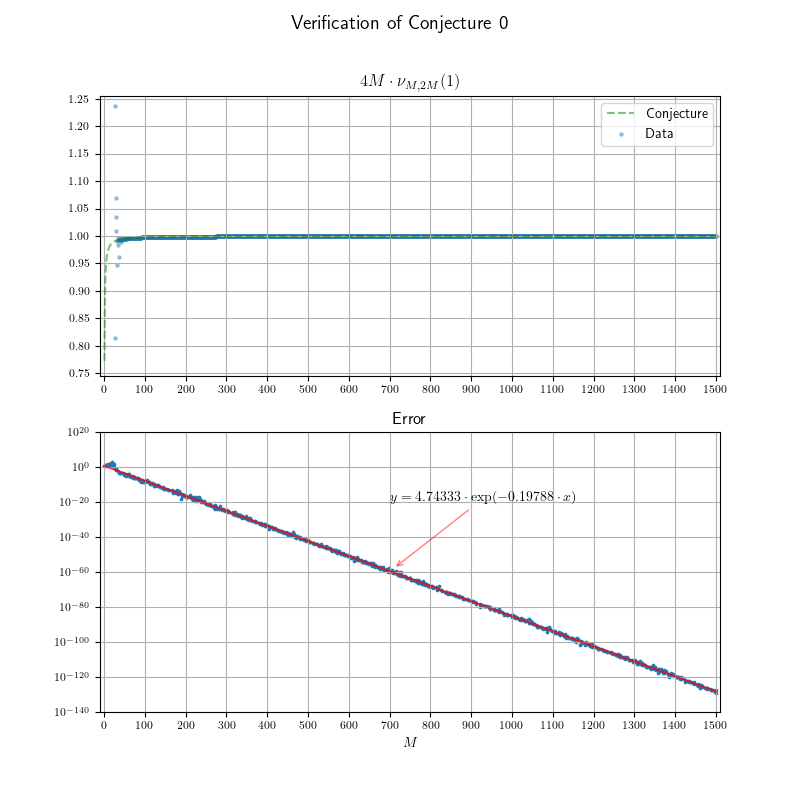

In [7]:
fig1,ax1 = plt.subplots(2,1)
fig1.set_size_inches((8,8))
fig1.suptitle("Verification of Conjecture 0", fontsize=14)

ax1[0].plot(nu_theo.index, nu_theo, '--', color='green', label="Conjecture", alpha=0.5)
ax1[0].scatter(nu_even.index, nu_even, s=10, lw=0, label="Data", alpha=0.5)
axis_format(ax1[0], r"$4M \cdot \nu_{M,2M}(1)$", "", "", range(0,1600,100), np.arange(0.75,1.3,0.05), 10,0.005)
ax1[0].legend()

ax1[1].scatter(dif.index, dif, s=7, lw=0)
ax1[1].plot(dif.index, regr, color='red', alpha=0.7)
ax1[1].annotate(fr"$y = {round(10**b,5)} \cdot \exp({round(m * np.log(10),5)} \cdot x)$", xy=(710,10**-58), xytext=(700,10**-20), arrowprops=dict(color='red',arrowstyle='->',linewidth=1, alpha=0.5))
ax1[1].set_yscale('log')
axis_format(ax1[1], "Error", r"$M$", "", range(0,1600,100), 10.0**(np.arange(-140,40,20)), 10)

The bottom plot shows that the error term for the asymptotic equivalence in Conjecture 0 is of the form $10^{{a M + b}}$ for constants $a, \, b$.

_Question 0.1_: How does the translate
$$
    M \mapsto 4M \cdot \nu_{M+k,2M}(1)
$$
behaves for different values of $k$?

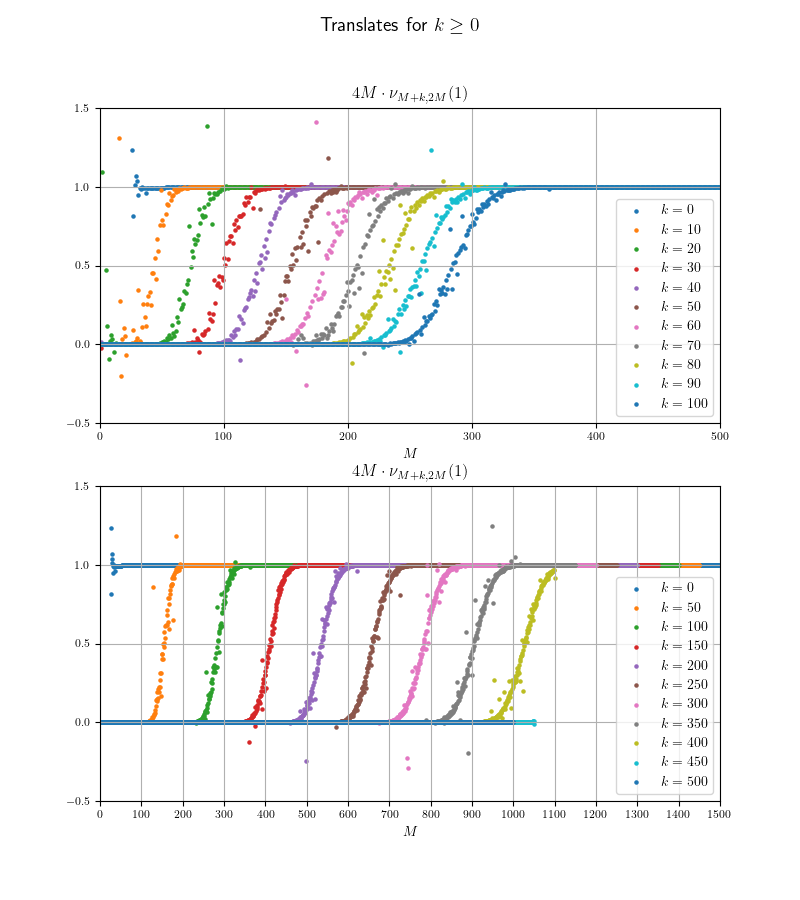

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


In [8]:
fig2,ax2 = plt.subplots(2,1)
fig2.set_size_inches((8,9))
fig2.suptitle("Translates for $k \geq 0$", fontsize=14)

incr=[range(0,110,10),range(0,550,50)]
tk=[range(0,600,100),range(0,1600,100)]

for i in range(2):
    for j in incr[i]:
        data = nu_levelc["nu_even"].loc[j]
        ax2[i].scatter(data.index, data, s=5, label=fr'$k={j}$')
    axis_format(ax2[i], r"$4M \cdot \nu_{M+k,2M}(1)$", r"$M$", "", tk[i], np.linspace(-0.5,1.5,5))
    ax2[i].legend()

Let's examine the simple continued fraction of the values of one of these offsets, say $k = 100$.

In [9]:
for m in nu_levelc["nu_even"].loc[100].index[9::10]:
    print(f'M = {m}: {nu_levelc["nu_even"].loc[100,m].scf(20)}')

M = 10: [0, 378795800873355771011353314833766915022613683, 1, 2, 38, 5, 1, 1, 26, 1, 2, 2, 2, 5, 6, 2, 9, 2, 1, 1, 1]
M = 20: [0, 2490461957578612279289718069662856259308861971700547, 766, 1, 9, 1, 3, 2, 3, 4, 1, 2, 2, 1, 11, 1, 1, 4, 25, 1, 1]
M = 30: [-1, 1, 216503973740176449212754562083850575848739410908859995350041, 6, 1, 5, 2, 1, 2, 1, 2, 14, 3, 1, 11, 6, 1, 17, 1, 1, 1]
M = 40: [0, 1079183361977677447353731325731432928320432096319486522383380671892, 8, 1, 16, 1, 4, 1, 2, 1, 1, 1, 3, 13, 1, 1, 1, 1, 1, 2, 3]
M = 50: [0, 64576161788147745885163616023454802026153369740489394842542, 1, 1, 1, 1, 3, 1, 1, 6, 8, 1, 1, 5, 1, 1, 1, 23, 47, 1, 6]
M = 60: [0, 16720142652903263383741910604082798233099544057154656, 3, 1, 7, 5, 2, 1, 4, 2, 2, 1, 1, 1, 3, 3, 1, 5, 1, 3, 15]
M = 70: [0, 8683968627551435379112506882045069044512554023, 1, 31, 2, 9, 1, 8, 5, 18, 1, 3, 9, 4, 3, 4, 1, 14, 1, 10, 20]
M = 80: [0, 27457765350204865470899251641859896989833, 5, 1, 2, 1, 1, 1, 2, 3, 4, 1, 1, 2, 9, 1, 6, 5

According to these results, we make the following conjecture:

__Conjecture 1__: For every positive integer $k$, we have the asymptotic equivalence
$$
    \nu_{M+k,2M}(1) \sim \Phi(-1,1,2M+1)
$$
as $M \to \infty$. Increasing $k$, we also increase the threshold for $M$ where the conjecture begins to hold.

Let us now examine the error term 
$$
    4M \cdot \big(\nu_{M+k,2M}(1) - \Phi(-1,1,2M+1)\big)
$$
for various values of $k$.

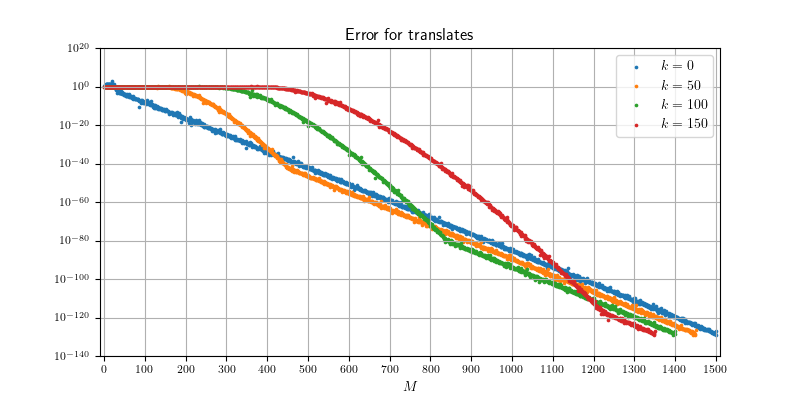

In [9]:
fig3,ax3 = plt.subplots()
fig3.set_size_inches((8,4))
#fig1.suptitle("Verification of Conjecture 0", fontsize=14)

for i in range(0,200,50):
    dif = nu_levelc.loc[i,'dif_even'].transform(abs)
    ax3.scatter(dif.index, dif, s=7, lw=0, label=fr'$k={i}$')

ax3.set_yscale('log')
axis_format(ax3, "Error for translates", r"$M$", "", range(0,1600,100), 10.0**(np.arange(-140,40,20)), 10)
ax3.legend()

The logarithm of the error seems to decrease linearly with $M$ for large enough values of $M$. This trend establishes itself after an abrupt transition. We identified visually the transition points in the logarithmic error curves for $k \in \{0, 10, 20, ..., 160\}$. The following plot hints at a sublinear behavior; more data is needed to produce more conjectures on their behavior.

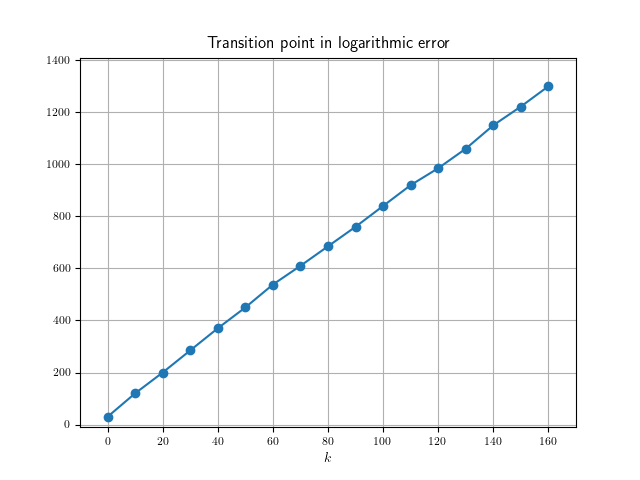

In [16]:
## ATTEMPT OF A CODE TO DETECT THE CORNERS AUTOMATICALLY
# def corner_id(data,discarded,window_size,degree):
#     from scipy.signal import savgol_filter

#     data_smooth = savgol_filter(data.values, window_size, degree)
#     dx = data.index[discarded:-discarded] 
#     dy = np.diff(data_smooth)
#     dy = np.append(dy,dy[-1])[discarded:-discarded]

#     corner = dx[np.argmax([abs(dy[i+window_size]-dy[i]) for i in range(len(dy)-window_size)])] + window_size // 2
#     return corner

# corners=[]
# for i in range(10,160,10):
#     dif = nu_levelc.loc[i,'dif_even'].transform(lambda x: mpm.log10(abs(x)))
#     corners.append(corner_id(dif,50,30,5))

corners = np.array([30,120,200,285,370,450,538,610,685,760,840,920,985,1060,1150,1222,1300])
fig4,ax4 = plt.subplots()
ax4.plot(range(0,170,10),corners,'-o')
axis_format(ax4, "Transition point in logarithmic error", r"$k$", "", range(0,170,20), range(0,1600,200), 10, 10)

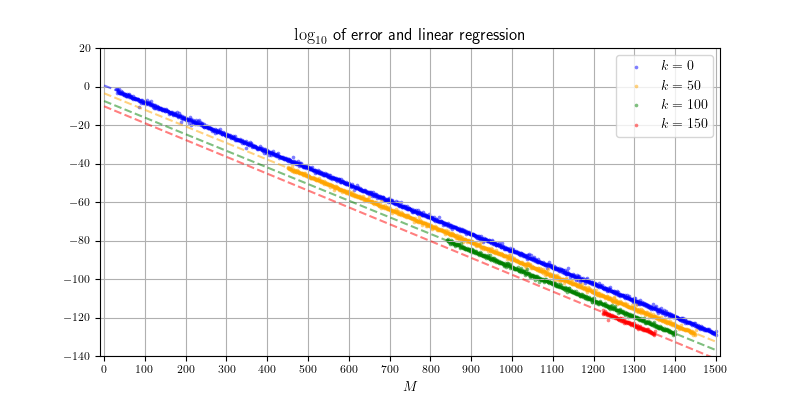

In [11]:
fig5,ax5 = plt.subplots()
fig5.set_size_inches((8,4))
fig1.suptitle("Verification of Conjecture 0", fontsize=14)

slopes = np.zeros(17)
abscissa = np.zeros(17)
colors=['blue','orange','green','red']
for i in range(0,170,10):
    dif = nu_levelc.loc[(i,corners[i//10]):i,'dif_even'].reset_index(level=0,drop=True).transform(lambda x: mpm.log10(abs(x)))
    slopes[i//10],abscissa[i//10] = np.polyfit(list(dif.index),[float(i) for i in dif.values],1)
    if i % 50 == 0:
        regr = [abscissa[i//10],slopes[i//10] * 1500 + abscissa[i//10]]
        ax5.scatter(dif.index, dif, s=7, lw=0, label=fr'$k={i}$', color=colors[(i//50) % 4], alpha=0.5)
        ax5.plot([0, 1500], regr, '--', color=colors[(i//50) % 4], alpha=0.5)

axis_format(ax5, "$\log_{{10}}$ of error and linear regression", r"$M$", "", range(0,1600,100), np.arange(-140,40,20), 10)
ax5.legend()

In [26]:
print("Results of linear regression (y = - ax - b) for different values of k \n")
for k in range(0,170,10):
    print(f"k = {k}:  \t a = {-slopes[k//10]},\t b = {-abscissa[k//10]}")

Results of linear regression (y = - ax - b) for different values of k 

k = 0:  	 a = 0.08581474615777718,	 b = -0.5513852042209831
k = 10:  	 a = 0.08589126269266414,	 b = 0.22869794001329224
k = 20:  	 a = 0.0859630138850373,	 b = 1.0127224048130168
k = 30:  	 a = 0.08596717132736385,	 b = 1.8680700296901833
k = 40:  	 a = 0.08602013232361799,	 b = 2.670002608571662
k = 50:  	 a = 0.08602915588629881,	 b = 3.5201357518389704
k = 60:  	 a = 0.0860128962383139,	 b = 4.399183674113592
k = 70:  	 a = 0.08606123391705434,	 b = 5.203822354291886
k = 80:  	 a = 0.08608152005980892,	 b = 6.039956563058875
k = 90:  	 a = 0.08616207949231675,	 b = 6.805485342034507
k = 100:  	 a = 0.08626675763982901,	 b = 7.5402023890019665
k = 110:  	 a = 0.08625673410739503,	 b = 8.414858551805256
k = 120:  	 a = 0.08650008949451596,	 b = 8.974836898167025
k = 130:  	 a = 0.08700438824771112,	 b = 9.195879543780405
k = 140:  	 a = 0.08623886611905349,	 b = 11.037418058204501
k = 150:  	 a = 0.08749590291450

The results of linear regression for different values of $k$ show that the slope and intercept increase in magnitude; the slope at a slower rater.

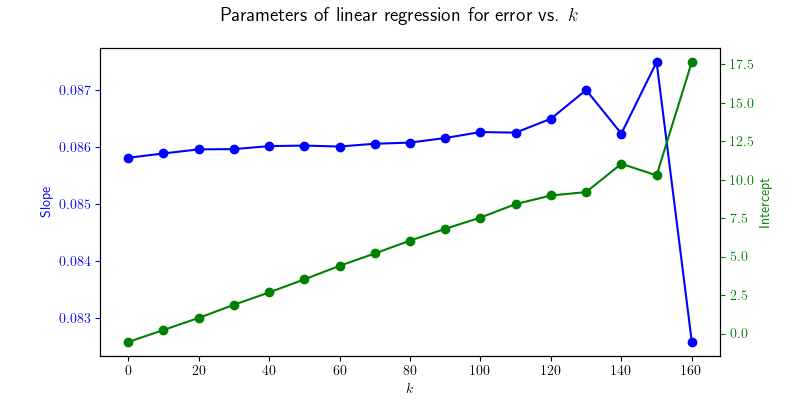

In [27]:
fig6,ax6 = plt.subplots()
ax6a = ax6.twinx()
fig6.set_size_inches((8,4))
fig6.suptitle("Parameters of linear regression for error vs. $k$", fontsize=14)

ax6.plot(range(0,170,10),-slopes,'-o',color='blue')
ax6.set_xlabel(r'$k$')
ax6.set_ylabel('Slope',color='blue')
ax6.tick_params(axis='y', color='blue', labelcolor='blue')
ax6a.plot(range(0,170,10),-abscissa,'-o',color='green')
ax6a.set_ylabel('Intercept',color='green')
ax6a.tick_params(axis='y', color='green', labelcolor='green')

This results in the following conjecture:

__Conjecture 2:__ There exist a function $M_0: \mathbb{N} \to \mathbb{N}$ and unique functions $\alpha, \beta: \mathbb{N} \to \mathbb{R}_{\geq 0}$ such that 
$$
    \Big|\nu_{M+k,2M}(1) - \Phi(-1,1,2M+1)\Big| = 10^{\, -(\alpha(k)\cdot M + \beta(k))}
$$
for all $M \geq M_0(k)$.

__(Weak!) Conjecture 2a:__ 
1. The function $\beta$ increases linearly. 
2. The function $\alpha$ increases at a "low (and unknown) rate" (it could also be constant!). 
3. The smallest function $M_0$ that makes Conjecture 2 hold increases at a sublinear rate.


_Question 0.2:_ What happens with odd values of the second argument?

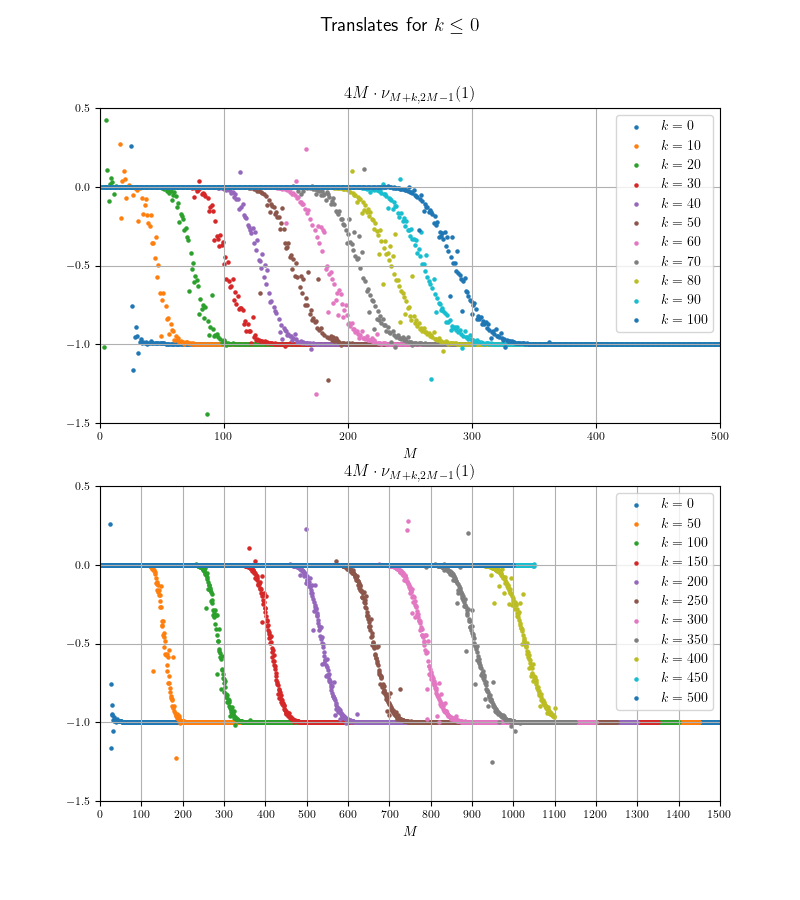

In [22]:
fig7,ax7 = plt.subplots(2,1)
fig7.set_size_inches((8,9))
fig7.suptitle("Translates for $k \leq 0$", fontsize=14)

incr=[range(0,110,10),range(0,550,50)]
tk=[range(0,600,100),range(0,1600,100)]

for i in range(2):
    for j in incr[i]:
        data = nu_levelc["nu_odd"].loc[j]
        ax7[i].scatter(data.index, data, s=5, label=fr'$k={j}$')
    axis_format(ax7[i], r"$4M \cdot \nu_{M+k,2M-1}(1)$", r"$M$", "", tk[i], np.linspace(-1.5,0.5,5))
    ax7[i].legend()

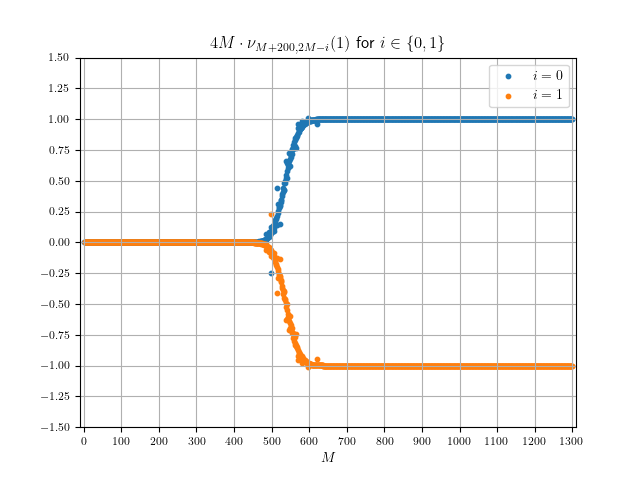

In [25]:
fig8,ax8 = plt.subplots()
fig8.suptitle("",fontsize=14)

ax8.scatter(nu_levelc["nu_even"].loc[200].index, nu_levelc["nu_even"].loc[200],s=10,label='$i=0$')
ax8.scatter(nu_levelc["nu_even"].loc[200].index, nu_levelc["nu_odd"].loc[200],s=10,label='$i=1$')
axis_format(ax8, r"$4M \cdot \nu_{M+200,2M-i}(1)$ for $i \in \{0,1\}$", r"$M$", "", range(0,1400,100), np.linspace(-1.5,1.5,13), 10)
ax8.legend()

_Conjecture 2:_ For every negative integer $k$ and $M$ sufficiently large, we have the equality
$$
    \nu_{M+k,2M-1}(1) = \Phi(-1,1,2M)= -\left(\log 2 - \sum_{n=1}^{2M-1} \frac{(-1)^{n-1}}{n}\right)
$$ 

10000


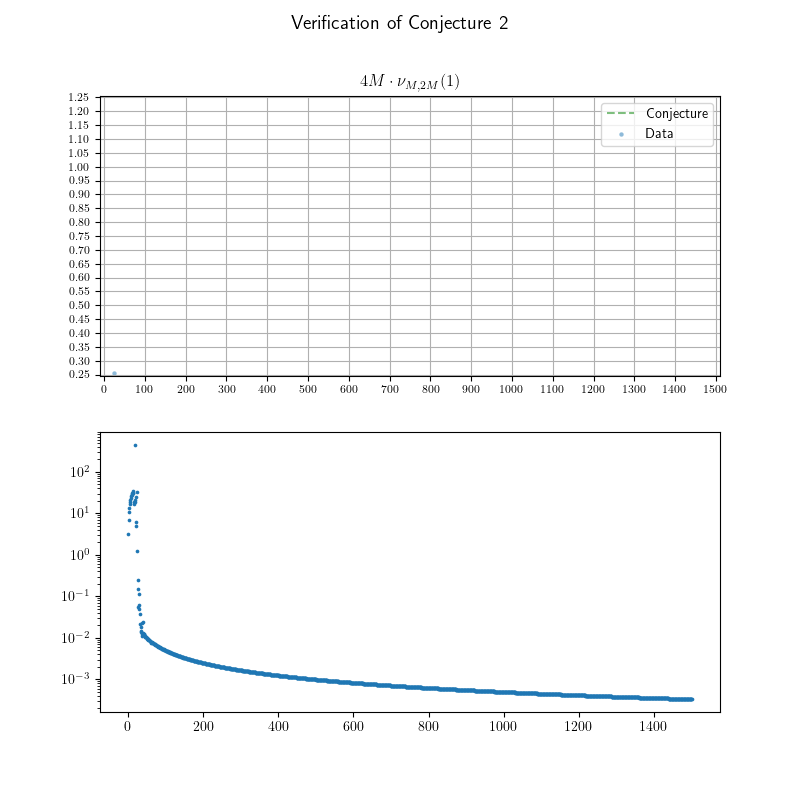

In [133]:
fig5,ax5 = plt.subplots(2,1)
fig5.set_size_inches((8,8))
fig5.suptitle("Verification of Conjecture 2", fontsize=14)

nu_odd_0 = nu_levelc["nu_odd"].loc[0]
nu_theo_odd_0 = pd.Series({m: 4*m*(mpm.log(2)-mpm.nsum(lambda n: (-1)**(n-1)/n, [1,2*m-1])) for m in nu_odd_0.index})

ax5[0].plot(nu_theo_odd_0, '--', color='green', label="Conjecture", alpha=0.5)
ax5[0].scatter(nu_odd_0.index, nu_odd_0, s=10, lw=0, label="Data", alpha=0.5)
axis_format(ax5[0], r"$4M \cdot \nu_{M,2M}(1)$", "", "", range(0,1600,100), np.arange(0.25,1.3,0.05), 10,0.005)
ax5[0].legend()

print(mpm.mp.dps)
diff = abs(nu_levelc["nu_odd"].loc[0] - nu_theo_odd_0)
ax5[1].scatter(nu_even_0.index, diff, s=7, lw=0)
ax5[1].set_yscale('log')
#axis_format(ax1[1], "Difference", r"$M$", "", range(0,1600,100), 10.0**(np.arange(-140,40,20)), 10)

Conjecture 1: A formula that explains the dependency on $s$ of $\nu_{M,K}(s)$.

In order to explain this behaviour, we will plot $\nu_{M,K}(s)$ as a function of $M$ for fixed values of $K$ and $s$.

In [51]:
plt.cla()

plt.scatter(range(200,3002,2), Y1)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Graph Title')
plt.grid(True)

plt.show()

NameError: name 'Y1' is not defined

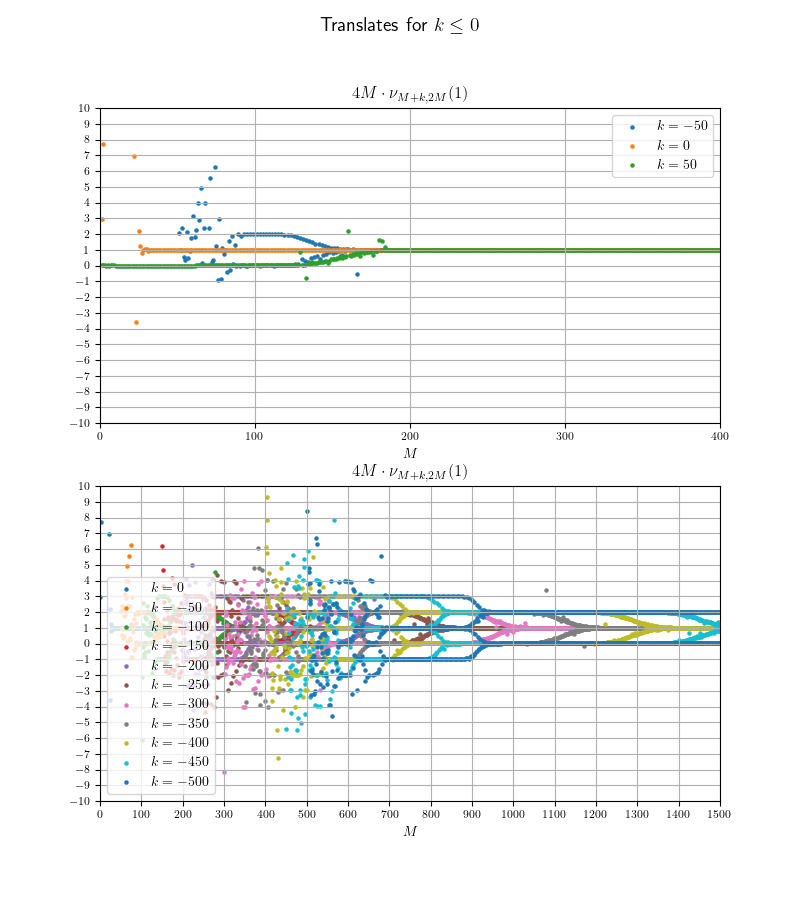

In [119]:
fig6,ax6 = plt.subplots(2,1)
fig6.set_size_inches((8,9))
fig6.suptitle("Translates for $k \leq 0$", fontsize=14)

incr=[range(-50,100,50),range(0,-550,-50)]
tk=[range(0,500,100),range(0,1600,100)]

for i in range(2):
    for j in incr[i]:
        data = nu_levelc["nu_even"].loc[j]
        ax6[i].scatter(data.index, data, s=5, label=fr'$k={j}$')
    axis_format(ax6[i], r"$4M \cdot \nu_{M+k,2M}(1)$", r"$M$", "", tk[i], np.linspace(-10,10,21))
    ax6[i].legend()